This notebook illustrates how to extract a weak ground truth of healthy and cancer cell bounding boxes from IHC patches. This code can be wrapped in a set of for-loops for batch processing.

In [1]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from library_utils import *

First, a stain decomposition is performed:

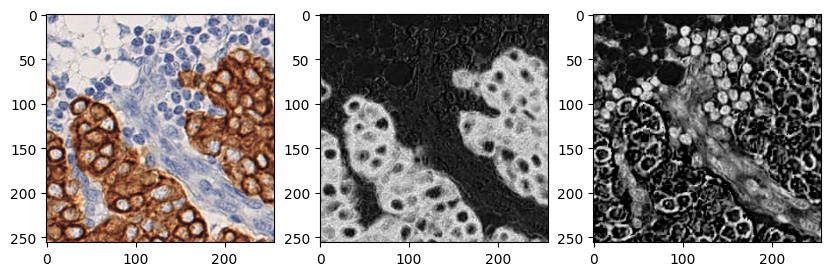

In [2]:
patches_file = 'IHC_patches.h5'

x_images = h5py.File(patches_file, 'r')['x']

tile_idx = 0

input_img = x_images[tile_idx]

ihc_h, _, ihc_d = decompose_ihc(input_img)
ihc_d_gray = rgb2gray(ihc_d)
ihc_h_gray = rgb2gray(ihc_h)

fig, axes = plt.subplots(ncols=3, figsize=(10, 5))

axes[0].imshow(input_img)
axes[1].imshow(ihc_d_gray, cmap='Greys')
axes[2].imshow(ihc_h_gray, cmap='Greys')

Unlike H&E images, IHC images do not require a manually annotated expert to identify metastatic regions; the diaminobenzidine (DAB) stain provides a soft segmentation that we can readily exploit by thresholding. The "islands" in the resulting mask correspond to the nuclei of cancer cells. With an aggressive morphological closing, we obtain a final mask of the metastatic regions.

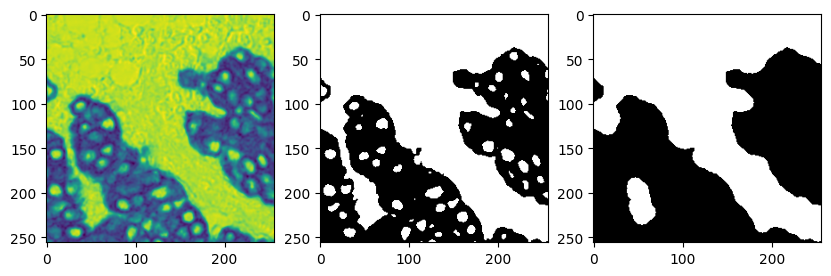

In [3]:
filtered_img = gaussian(ihc_d_gray, sigma=1)
T = threshold_otsu(filtered_img)
mask = 1 - (filtered_img > T)
full_mask = closing(mask, disk(9))

fig, axes = plt.subplots(ncols=3, figsize=(10, 5))

axes[0].imshow(filtered_img)
axes[1].imshow(mask, cmap='Greys')
axes[2].imshow(full_mask, cmap='Greys')

Next, we perform blob detection to locate both normal and cancer cells. The initial result will contain many false positives and negatives, but the region mask computed above will have the final say.

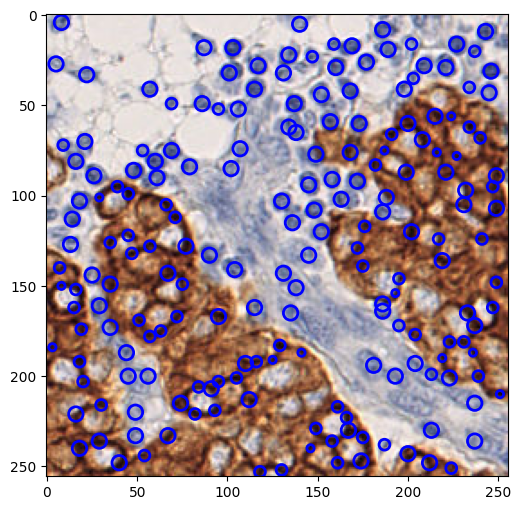

In [4]:
ihc_h_gray = rgb2gray(ihc_h)

gauss_sigma = 2
min_sigma = 1
max_sigma = 3
threshold = 0.08

normal_blobs = get_cells(ihc_h_gray, gauss_sigma, min_sigma, max_sigma, threshold)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(input_img)

for blob in normal_blobs:
    y, x, r = map(int, blob)
    c = plt.Circle((x, y), r, color='blue', linewidth=2, fill=False)
    ax.add_patch(c)

plt.show()

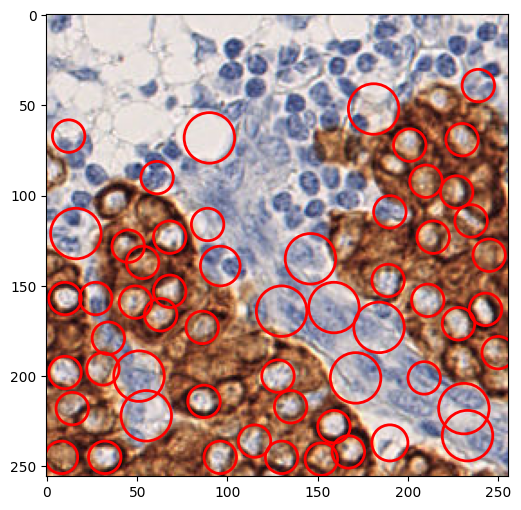

In [5]:
gauss_sigma = 2
min_sigma = 7
max_sigma = 10
threshold = 0.02

cancer_blobs = get_cells(1 - ihc_d_gray, gauss_sigma, min_sigma, max_sigma, threshold)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(input_img)

for blob in cancer_blobs:
    y, x, r = map(int, blob)
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

plt.show()

We now apply the full mask to filter out cells detected in their respective mask regions, eliminating any false positives. Note we first apply the following *ad hoc* rule: when the average of the DAB channel is too high (little to no metastatis), we remove dicard all positives by setting the mask to $0$. In a final step, the bounding boxes are written to a `pandas.DataFrame`:

In [6]:
if np.mean(ihc_d_gray) > 0.85:
    full_mask *= 0

cancer_cells, normal_cells = [], []

for blob in cancer_blobs:
    y, x, r = map(int, blob)
    if full_mask[y, x]:
        cancer_cells.append((y, x))

for blob in normal_blobs:
    y, x, r = map(int, blob)
    if not full_mask[y, x]:
        normal_cells.append((y, x))
        
bbox_data = []

crops, bboxes = get_crops_image(input_img, normal_cells)
bboxes = [[patches_file] + [tile_idx] + bbox + [0] for bbox in bboxes]
bbox_data.extend(bboxes)

crops, bboxes = get_crops_image(input_img, cancer_cells)
bboxes = [[patches_file] + [tile_idx] + bbox + [1] for bbox in bboxes]
bbox_data.extend(bboxes)

columns = ['patch_file', 'tile', 'xmin', 'ymin', 'xmax', 'ymax', 'class']
index = np.arange(len(bbox_data))
file_name = '%s.csv' % patches_file.split('.')[0]

df_bboxes = pd.DataFrame(bbox_data, columns=columns, index=index)
df_bboxes.head()

,patch_file,tile,xmin,ymin,xmax,ymax,class
0,IHC_patches.h5,0,149,36,197,84,0
1,IHC_patches.h5,0,113,25,161,73,0
2,IHC_patches.h5,0,144,18,192,66,0
3,IHC_patches.h5,0,33,17,81,65,0
4,IHC_patches.h5,0,91,17,139,65,0


We visualise the result. At train time the bounding boxes can be randomly subsampled and balanced:

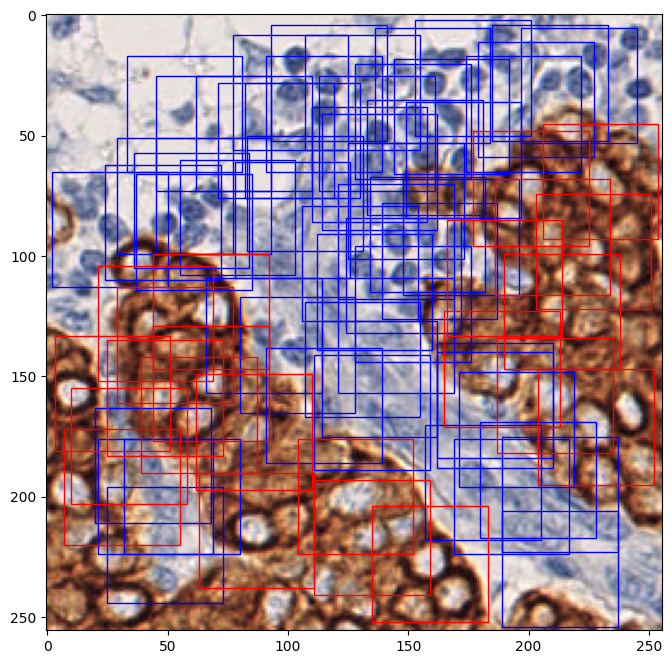

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(input_img)

for i, row in df_bboxes[df_bboxes.tile == tile_idx].iterrows():
    xmin, ymin, xmax, ymax, cls = row[['xmin', 'ymin', 'xmax', 'ymax', 'class']]

    color = 'r' if cls else 'b'
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                             linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)